In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import holidays
from collections import Counter

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from geopy.distance import geodesic # геодезическое расстояние между точками по поверхности Земли

from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv',nrows=1000000)
# df = pd.read_csv('train.csv')

In [3]:
df.dropna(inplace=True)

In [4]:
len(df)

999990

In [5]:
df.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
# убираем неверные координаты
df = df[(df['dropoff_latitude']<=90) & (df['dropoff_latitude']>=-90) & (df['dropoff_longitude']<=90) & (df['dropoff_longitude']>=-90)]

In [8]:
# убираем неверные координаты
df = df[(df['pickup_latitude']<=90) & (df['pickup_latitude']>=-90) & (df['pickup_longitude']<=90) & (df['pickup_longitude']>=-90)]

In [9]:
import pandas as pd
import numpy as np

# Предположим, что данные в формате DataFrame с колонками "pickup_latitude", "pickup_longitude",
# "dropoff_latitude", "dropoff_longitude"

# Определим размеры ячейки (приблизительно 1 км)
LATITUDE_GRID_SIZE = 1 / 111  # ~1 км по широте
LONGITUDE_GRID_SIZE = 1 / 85  # ~1 км по долготе в Нью-Йорке

# Функция для получения индекса ячейки по координатам
def get_grid_index(lat, lon, lat_grid_size, lon_grid_size):
    lat_idx = int(lat / lat_grid_size)
    lon_idx = int(lon / lon_grid_size)
    return lat_idx, lon_idx

# Добавляем индексы ячеек для точек посадки и высадки
df['dropoff_grid'] = df.apply(lambda row: get_grid_index(
    row['dropoff_latitude'], row['dropoff_longitude'], LATITUDE_GRID_SIZE, LONGITUDE_GRID_SIZE), axis=1)

# Присваиваем уникальный идентификатор для каждой зоны
df['dropoff_grid_lat'] = df['dropoff_grid'].apply(lambda x: x[0])
df['dropoff_grid_lon'] = df['dropoff_grid'].apply(lambda x: x[1])

df.drop(columns=['dropoff_grid'], inplace=True)

In [10]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Радиус Земли в километрах
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    return R * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))

In [11]:
df['distance'] = haversine_distance(df['pickup_latitude'], df['pickup_longitude'],
                                      df['dropoff_latitude'], df['dropoff_longitude'])
df['airport_distance'] = haversine_distance(40.646746, -73.789962,
                                      df['dropoff_latitude'], df['dropoff_longitude'])

In [12]:
# приведение к времени нью йорка
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).dt.tz_convert('America/New_York')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).dt.tz_convert(None)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999944 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   key                999944 non-null  object        
 1   fare_amount        999944 non-null  float64       
 2   pickup_datetime    999944 non-null  datetime64[ns]
 3   pickup_longitude   999944 non-null  float64       
 4   pickup_latitude    999944 non-null  float64       
 5   dropoff_longitude  999944 non-null  float64       
 6   dropoff_latitude   999944 non-null  float64       
 7   passenger_count    999944 non-null  int64         
 8   dropoff_grid_lat   999944 non-null  int64         
 9   dropoff_grid_lon   999944 non-null  int64         
 10  distance           999944 non-null  float64       
 11  airport_distance   999944 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(3), object(1)
memory usage: 99.2+ MB


In [13]:
# определение дня недели
df['weekday'] = df['pickup_datetime'].dt.weekday
# Создаем новые колонки
df['minute'] = df['pickup_datetime'].dt.minute
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year

In [14]:
df.drop(columns=['pickup_datetime'], inplace=True)

In [15]:
df

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dropoff_grid_lat,dropoff_grid_lon,distance,airport_distance,weekday,minute,hour,day,month,year
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,4519,-6276,1.030764,8.489197,0,26,17,15,6,2009
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,4526,-6288,8.450134,21.926447,1,52,16,5,1,2010
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,4523,-6289,1.389525,20.522801,3,35,0,18,8,2011
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4524,-6289,2.799270,21.026543,5,30,4,21,4,2012
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,4526,-6286,1.999157,20.724317,1,51,7,9,3,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2014-09-13 21:44:38.0000001,7.0,-73.976676,40.785630,-73.959196,40.775114,1,4526,-6286,1.879763,20.179457,5,44,21,13,9,2014
999996,2010-09-20 14:50:37.0000002,7.3,-73.992103,40.671385,-73.992103,40.671385,2,4514,-6289,0.000000,17.269794,0,50,14,20,9,2010
999997,2013-04-26 14:03:00.000000118,10.5,-73.978423,40.751135,-73.993397,40.762197,5,4524,-6289,1.761741,21.421385,4,3,14,26,4,2013
999998,2011-07-08 00:29:00.00000099,6.9,-73.980317,40.759482,-73.976832,40.743122,1,4522,-6288,1.842683,19.053788,4,29,0,8,7,2011


In [16]:
# from matplotlib.colors import LinearSegmentedColormap
# from matplotlib import pyplot as plt

# plt.figure(figsize=(10,10))

# cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])

# f, ax = plt.subplots()
# points = ax.scatter(df['dropoff_longitude'], df['dropoff_latitude'], c=df['fare_amount'],
#                     s=10, cmap=cmap)
# f.colorbar(points)

In [17]:
X = df.drop(columns=['fare_amount', 'key'])
X

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dropoff_grid_lat,dropoff_grid_lon,distance,airport_distance,weekday,minute,hour,day,month,year
0,-73.844311,40.721319,-73.841610,40.712278,1,4519,-6276,1.030764,8.489197,0,26,17,15,6,2009
1,-74.016048,40.711303,-73.979268,40.782004,1,4526,-6288,8.450134,21.926447,1,52,16,5,1,2010
2,-73.982738,40.761270,-73.991242,40.750562,2,4523,-6289,1.389525,20.522801,3,35,0,18,8,2011
3,-73.987130,40.733143,-73.991567,40.758092,1,4524,-6289,2.799270,21.026543,5,30,4,21,4,2012
4,-73.968095,40.768008,-73.956655,40.783762,1,4526,-6286,1.999157,20.724317,1,51,7,9,3,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-73.976676,40.785630,-73.959196,40.775114,1,4526,-6286,1.879763,20.179457,5,44,21,13,9,2014
999996,-73.992103,40.671385,-73.992103,40.671385,2,4514,-6289,0.000000,17.269794,0,50,14,20,9,2010
999997,-73.978423,40.751135,-73.993397,40.762197,5,4524,-6289,1.761741,21.421385,4,3,14,26,4,2013
999998,-73.980317,40.759482,-73.976832,40.743122,1,4522,-6288,1.842683,19.053788,4,29,0,8,7,2011


In [18]:
y = df['fare_amount']
y

0          4.5
1         16.9
2          5.7
3          7.7
4          5.3
          ... 
999995     7.0
999996     7.3
999997    10.5
999998     6.9
999999     4.1
Name: fare_amount, Length: 999944, dtype: float64

In [19]:
quantile_bins = pd.qcut(y, q=20, precision=1, labels=False)
quantile_bins.head(), quantile_bins.tail()

(0     1
 1    17
 2     4
 3     8
 4     3
 Name: fare_amount, dtype: int64,
 999995     7
 999996     7
 999997    12
 999998     6
 999999     0
 Name: fare_amount, dtype: int64)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=quantile_bins)

In [21]:
cat_base = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.07,
    depth=8,
    l2_leaf_reg=5,
    eval_metric='RMSE',     # Метрика качества для регрессии
    random_seed=42,         # Сид для повторяемости результатов
    od_wait=1000,
    use_best_model=True,    
    verbose=200,             # Частота вывода информации о процессе обучения
    task_type='CPU'
)

In [22]:
cat_base.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 9.3257707	test: 9.4304489	best: 9.4304489 (0)	total: 221ms	remaining: 5m 31s
200:	learn: 4.1586237	test: 4.4107041	best: 4.4104458 (197)	total: 16.1s	remaining: 1m 44s
400:	learn: 4.0022188	test: 4.3371698	best: 4.3371545 (398)	total: 32.6s	remaining: 1m 29s
600:	learn: 3.8919385	test: 4.3041944	best: 4.3041944 (600)	total: 49.5s	remaining: 1m 14s
800:	learn: 3.8085322	test: 4.2829070	best: 4.2829070 (800)	total: 1m 5s	remaining: 57.6s
1000:	learn: 3.7412369	test: 4.2715298	best: 4.2712612 (993)	total: 1m 22s	remaining: 41s
1200:	learn: 3.6831098	test: 4.2641659	best: 4.2638818 (1188)	total: 1m 37s	remaining: 24.4s
1400:	learn: 3.6334619	test: 4.2601464	best: 4.2600685 (1399)	total: 1m 54s	remaining: 8.06s
1499:	learn: 3.6106471	test: 4.2587661	best: 4.2587661 (1499)	total: 2m 1s	remaining: 0us

bestTest = 4.258766119
bestIteration = 1499



In [23]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Feature Importance')

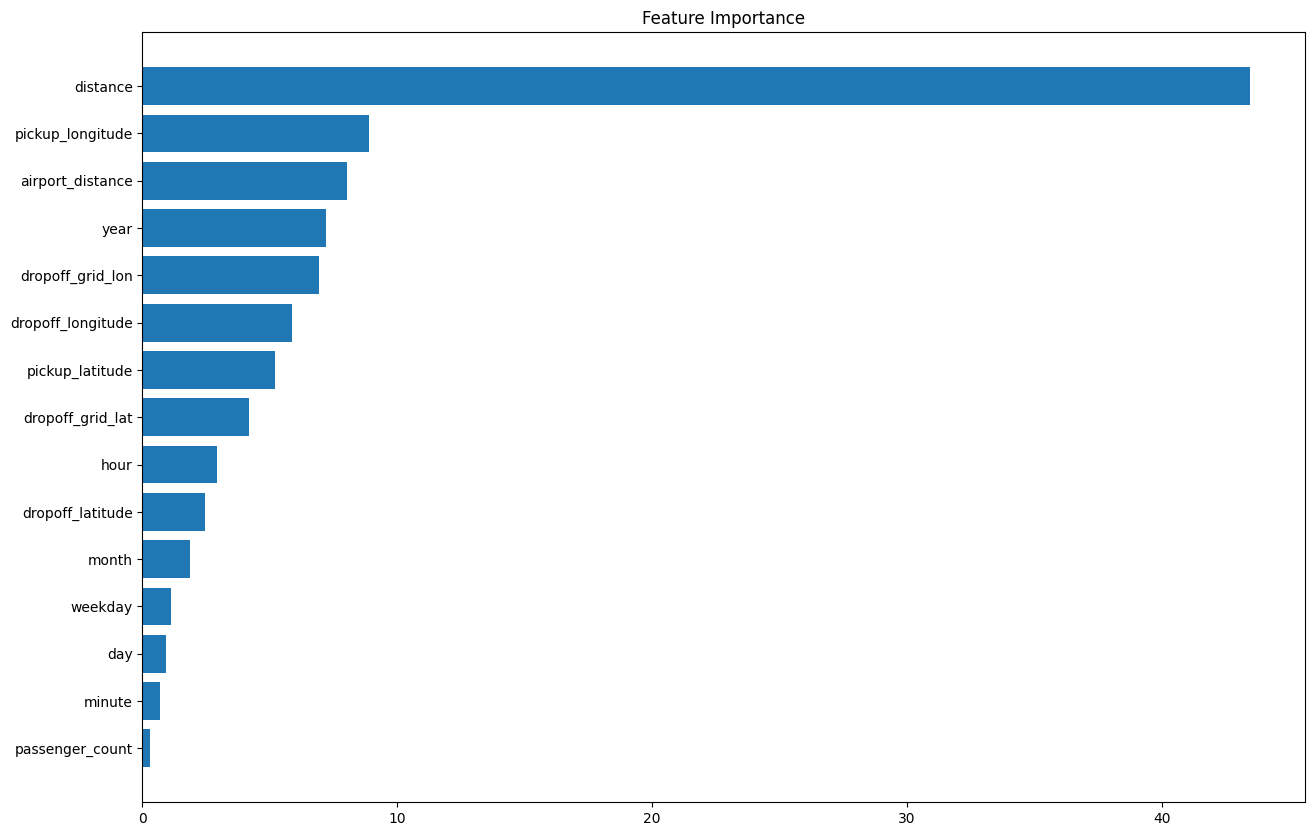

In [24]:
feature_importance = cat_base.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(15, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [25]:
predictions = cat_base.predict(X_test)

In [26]:
mean_squared_error(y_test, predictions, squared=False), mean_squared_error(y_test, predictions), r2_score(y_test, predictions)

(4.258766104934977, 18.13708873654303, 0.8151504286060326)

In [27]:
pred_df = pd.read_csv('test.csv')
pred_df

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51 UTC,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51 UTC,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15 UTC,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19 UTC,-73.985573,40.735432,-73.939178,40.801731,6


In [28]:
import pandas as pd
import numpy as np

# Предположим, что данные в формате DataFrame с колонками "pickup_latitude", "pickup_longitude",
# "dropoff_latitude", "dropoff_longitude"

# Определим размеры ячейки (приблизительно 1 км)
LATITUDE_GRID_SIZE = 1 / 111  # ~1 км по широте
LONGITUDE_GRID_SIZE = 1 / 85  # ~1 км по долготе в Нью-Йорке

# Функция для получения индекса ячейки по координатам
def get_grid_index(lat, lon, lat_grid_size, lon_grid_size):
    lat_idx = int(lat / lat_grid_size)
    lon_idx = int(lon / lon_grid_size)
    return lat_idx, lon_idx

# Добавляем индексы ячеек для точек посадки и высадки
pred_df['dropoff_grid'] = pred_df.apply(lambda row: get_grid_index(
    row['dropoff_latitude'], row['dropoff_longitude'], LATITUDE_GRID_SIZE, LONGITUDE_GRID_SIZE), axis=1)

# Присваиваем уникальный идентификатор для каждой зоны
pred_df['dropoff_grid_lat'] = pred_df['dropoff_grid'].apply(lambda x: x[0])
pred_df['dropoff_grid_lon'] = pred_df['dropoff_grid'].apply(lambda x: x[1])

pred_df.drop(columns=['dropoff_grid'], inplace=True)

In [29]:
pred_df['distance'] = haversine_distance(pred_df['pickup_latitude'], pred_df['pickup_longitude'],
                                      pred_df['dropoff_latitude'], pred_df['dropoff_longitude'])
pred_df['airport_distance'] = haversine_distance(40.646746, -73.789962,
                                      pred_df['dropoff_latitude'], pred_df['dropoff_longitude'])

In [30]:
# приведение к времени нью йорка
pred_df['pickup_datetime'] = pd.to_datetime(pred_df['pickup_datetime']).dt.tz_convert('America/New_York')
pred_df['pickup_datetime'] = pd.to_datetime(pred_df['pickup_datetime']).dt.tz_convert(None)
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                9914 non-null   object        
 1   pickup_datetime    9914 non-null   datetime64[ns]
 2   pickup_longitude   9914 non-null   float64       
 3   pickup_latitude    9914 non-null   float64       
 4   dropoff_longitude  9914 non-null   float64       
 5   dropoff_latitude   9914 non-null   float64       
 6   passenger_count    9914 non-null   int64         
 7   dropoff_grid_lat   9914 non-null   int64         
 8   dropoff_grid_lon   9914 non-null   int64         
 9   distance           9914 non-null   float64       
 10  airport_distance   9914 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(3), object(1)
memory usage: 852.1+ KB


In [31]:
# определение дня недели
pred_df['weekday'] = pred_df['pickup_datetime'].dt.weekday
# Создаем новые колонки
pred_df['minute'] = pred_df['pickup_datetime'].dt.minute
pred_df['hour'] = pred_df['pickup_datetime'].dt.hour
pred_df['day'] = pred_df['pickup_datetime'].dt.day
pred_df['month'] = pred_df['pickup_datetime'].dt.month
pred_df['year'] = pred_df['pickup_datetime'].dt.year

In [32]:
pred_df.drop(columns=['pickup_datetime'], inplace=True)

In [33]:
pred = cat_base.predict(pred_df.drop(columns=['key']))

In [34]:
sample = pd.read_csv('sample_submission.csv')
sample

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35
...,...,...
9909,2015-05-10 12:37:51.0000002,11.35
9910,2015-01-12 17:05:51.0000001,11.35
9911,2015-04-19 20:44:15.0000001,11.35
9912,2015-01-31 01:05:19.0000005,11.35


In [35]:
sample['fare_amount'] = pred
sample

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.487177
1,2015-01-27 13:08:24.0000003,11.198551
2,2011-10-08 11:53:44.0000002,4.668768
3,2012-12-01 21:12:12.0000002,8.719734
4,2012-12-01 21:12:12.0000003,16.026203
...,...,...
9909,2015-05-10 12:37:51.0000002,8.966619
9910,2015-01-12 17:05:51.0000001,11.185239
9911,2015-04-19 20:44:15.0000001,54.170372
9912,2015-01-31 01:05:19.0000005,20.588528


In [36]:
sample.to_csv('sub.csv', index=False)